# Fishery Data Exploration
The purpose of this competition on [Kaggle](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring) is to develop a model that classifies species of fish within a collection of images.  This notebook exhibits a brief exploration of the dataset and preprocesses the data for model development later.  Images are stored in the working directory folder 'data', sub-divided by train and test set.  The training set are also sub-divided by species, while the test_stg1 set are mixed and not separated by species folders.

#### Dependencies

In [79]:
import numpy as np
from scipy import ndimage, misc
import os
import matplotlib.pyplot as plt
%matplotlib inline



## Questions
### Are the images of similar aspect and pixel sizes?

In [2]:
print(os.listdir('data'))
print(os.listdir('data/train'))
print(os.listdir('data/train/ALB')[0:10])

['.DS_Store', 'test_stg1', 'test_stg1.zip', 'train', 'train.zip']
['.DS_Store', 'ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
['img_00003.jpg', 'img_00010.jpg', 'img_00012.jpg', 'img_00015.jpg', 'img_00019.jpg', 'img_00020.jpg', 'img_00029.jpg', 'img_00032.jpg', 'img_00037.jpg', 'img_00038.jpg']


In [3]:
for fish in os.listdir('data/train')[1:] :
    for image in os.listdir('data/train/'+fish)[0:3] :
        arr = ndimage.imread('data/train/'+fish+'/'+image, flatten = False)
        print("Shape: {}      Aspect Ratio: {:.2f}".format(arr.shape, arr.shape[1]/arr.shape[0]))

Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (974, 1280, 3)      Aspect Ratio: 1.31
Shape: (854, 1518, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (750, 1280, 3)      Aspect Ratio: 1.71
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (750, 1280, 3)      Aspect Ratio: 1.71
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (720, 1280, 3)      Aspect Ratio: 1.78
Shape: (974, 1280, 3)      Aspect 

**Answer:** Images appear to be of different pixel sizes and aspect ratios, and are RGB format.  

### How many of each fish species are present in the training set?

In [4]:
count = 0
for fish in os.listdir('/'.join(['data','train'])) :
    try : 
        print("{} contains {} images".format(fish, len(os.listdir('/'.join(['data','train',fish])))))
        count += len(os.listdir('/'.join(['data','train',fish])))
    #print(fish)
    except :
        pass
print("\nTOTAL TRAINING IMAGES: {}".format(count))                      

ALB contains 1719 images
BET contains 200 images
DOL contains 117 images
LAG contains 67 images
NoF contains 465 images
OTHER contains 299 images
SHARK contains 176 images
YFT contains 734 images

TOTAL TRAINING IMAGES: 3777


**Answer:** The counts of each fish are not equal in the training set.  Special precautions will be taken to avoid problems associated with unbalanced data sets.  3777 is not a vast amount for neural network training.  One potential strategy is to duplicate images with distortion in order to balance the dataset and provide extra training examples.  

## Experiment with image distortion techniques

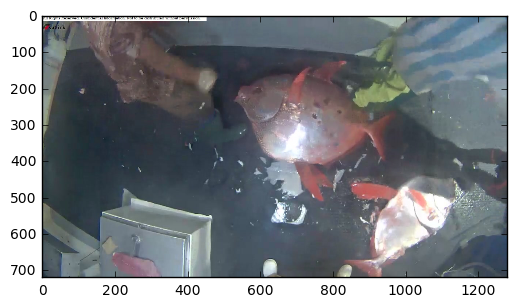

In [5]:
test_img = ndimage.imread('data/train/LAG/'+os.listdir('data/train/LAG')[0])
plt.imshow(test_img)
plt.show()

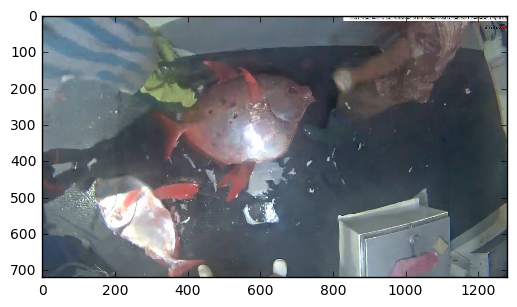

In [6]:
mod_test_img = np.fliplr(test_img)
plt.imshow(mod_test_img)
plt.show()

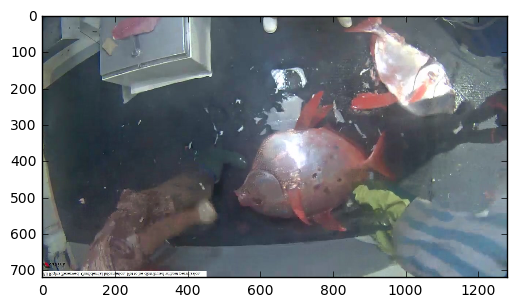

In [7]:
mod_test_img = np.flipud(test_img)
plt.imshow(mod_test_img)
plt.show()

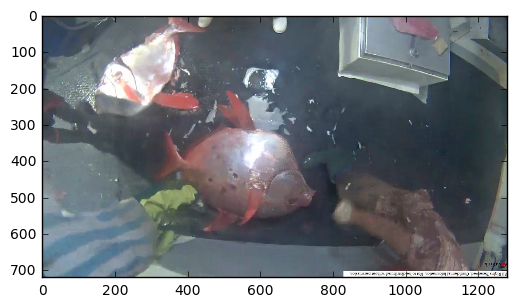

In [8]:
mod_test_img = np.flipud(np.fliplr(test_img))
plt.imshow(mod_test_img)
plt.show()

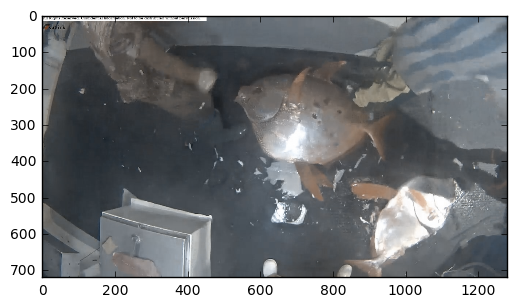

In [38]:
mod_test_img = ndimage.filters.gaussian_filter1d(test_img, 1, axis=-1, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
plt.imshow(mod_test_img)
plt.show()

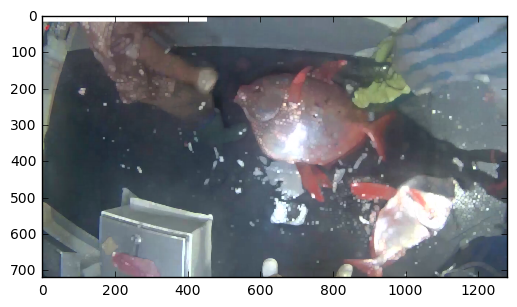

In [49]:
mod_test_img = ndimage.maximum_filter(test_img, size=(5,5,1), footprint=None, output=None, mode='reflect', cval=0.0, origin=0)
plt.imshow(mod_test_img)
plt.show()

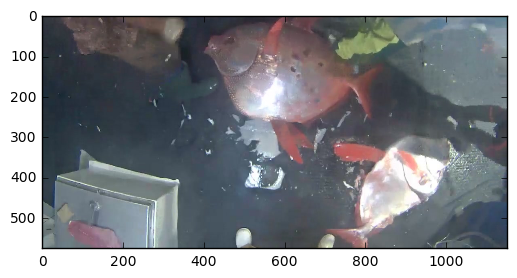

In [61]:
mod_test_img = test_img[test_img.shape[0]//5:, test_img.shape[1]//10:, :]
plt.imshow(mod_test_img)
plt.show()

In [78]:
mod_test_img = misc.resize(test_img, (750,1200,3))
plt.imshow(mod_test_img)
plt.show()

AttributeError: module 'scipy.ndimage' has no attribute 'resize'

### Design a function to mutate images randomly

In [68]:
def mutate_image(image) :
    "Receives an image and returns an image with a random set of distortions"
    assert len(image.shape) == 3 , 'Image is not in 3D'
    assert image.shape[2] == 3, 'Image is not in RGB format'
    
    flip_hor, flip_ver, sigma, vert_off, hor_off, top, left = [np.random.randint(0,2), 
                                                    np.random.randint(0,2), 
                                                    np.sqrt(np.random.random()), 
                                                    np.random.randint(5,15), 
                                                    np.random.randint(10,20),
                                                    np.random.randint(0,2),
                                                    np.random.randint(0,2)]
    #shift the image
    if top > 0 :
        if left > 0 :
            image_prime = test_img[image.shape[0]//vert_off:, test_img.shape[1]//hor_off:, :]
        else :
            image_prime = test_img[image.shape[0]//vert_off:, :-test_img.shape[1]//hor_off, :]
    else :
        if left > 0 :
            image_prime = test_img[:-image.shape[0]//vert_off, test_img.shape[1]//hor_off:, :]
        else :
            image_prime = test_img[:-image.shape[0]//vert_off, :-test_img.shape[1]//hor_off, :]
    
    if flip_hor > 0 : 
        image_prime = np.fliplr(image_prime)

    if flip_ver > 0 :
        image_prime = np.flipud(image_prime)
    return(ndimage.filters.gaussian_filter(image_prime, sigma))
    

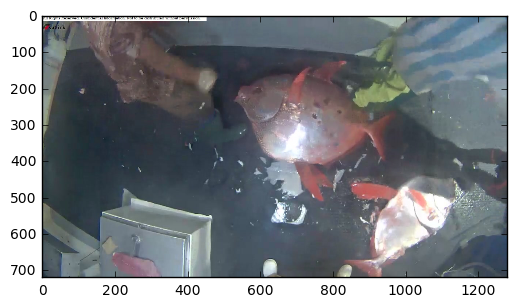

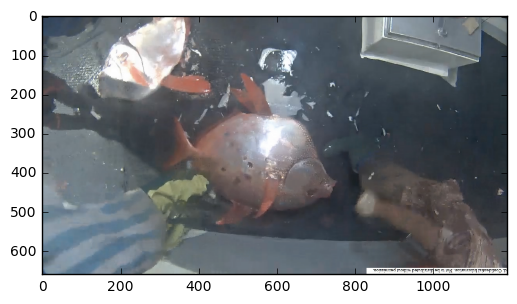

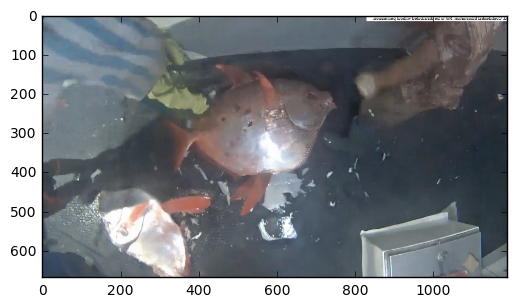

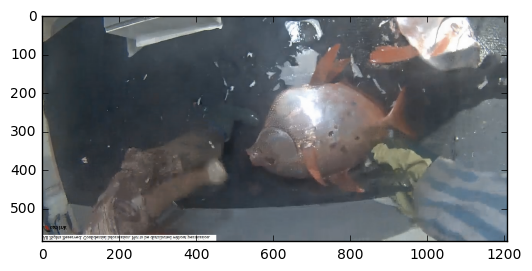

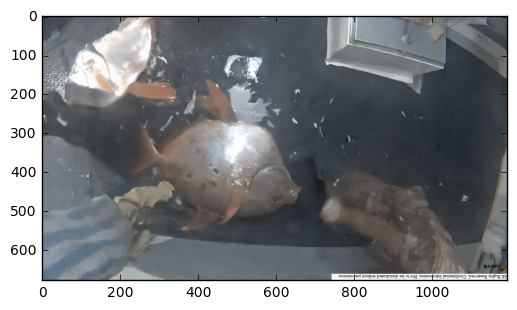

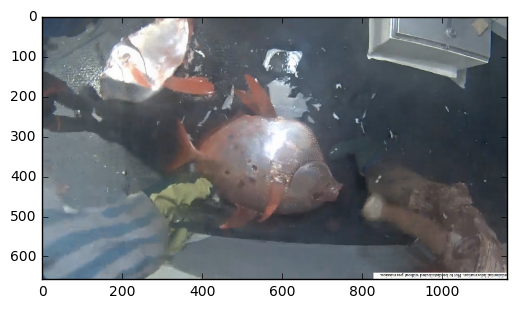

In [69]:
plt.imshow(test_img)
plt.show()
image = test_img
for i in range(5) :
    image = mutate_image(image)
    plt.imshow(image)
    plt.show()
    

## Preprocessing

### Design a function to download fish images and generate mutated offspring randomly 

In [76]:
def fish_lists(species, required_images) :
    """Function first brings all of the fish arrays into memory and then proceeds to mutate 
    at random in order to generate the requisite number of images. """
    
    image_list = []
    for image in os.listdir('data/train/'+species) :
        image_list.append(ndimage.imread('data/train/'+species+'/'+image))
    print("{} image arrays brough into the environment".format(len(image_list)))
    assert required_images > len(image_list), "More images than requested are present"
    images_required = required_images - len(image_list)
    
    for _ in range(images_required) :
        new_image = mutate_image(image_list[np.random.randint(0,len(image_list))])
        image_list.append(new_image)
    
    print("{} images arrays are now in the image_list".format(len(image_list)))
    
    ls_mean_height = np.mean( [x.shape[0] for x in image_list  ])
    ls_min_height = np.min( [x.shape[0] for x in image_list  ])
    ls_max_height = np.max([x.shape[0] for x in image_list  ])
    ls_mean_width = np.mean( [x.shape[1] for x in image_list  ])
    ls_min_width = np.min( [x.shape[1] for x in image_list  ])
    ls_max_width = np.max([x.shape[1] for x in image_list  ])
    
    print("Height: {} ({}-{})".format(ls_mean_height, ls_min_height, ls_max_height))
    print("Width: {} ({}-{})".format(ls_mean_width, ls_min_width, ls_max_width))
    return image_list
    

In [77]:
lag_test = fish_lists('LAG', 150)

117 image arrays brough into the environment
150 images arrays are now in the image_list
Height: 771.86 (525-974)
Width: 1259.4266666666667 (1152-1280)


### Function to standardize images and stack into an array

In [87]:
def standard_stack(image_list, std_y, std_x) :
    """Iterates through a list of images (e.g. from fish_lists fn) and 
    uses ndimage.resize to standardize each image to the same height and width.
    Finally, the list is stacked in the 0 dimension to create an array."""
    
    for i,image in enumerate(image_list) :
        image_list[i] = misc.imresize(image, (std_y, std_x, 3))  #keep all 3 channels
        
    return np.stack(image_list, 0)

In [ ]:
standard_stack(lag_test, 750, 1250).shape